In [1]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 100x100 with 0 Axes>

In [5]:
from mmml import dcmnet

In [6]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [23]:
NDCM = 7
model = MessagePassingModel(
    features=32, max_degree=2, num_iterations=2,
    num_basis_functions=32, cutoff=10.0, n_dcm=NDCM,
    include_pseudotensors=False,
)

## Data

In [2]:
current_path = Path.cwd()
print(current_path)
data_path = Path("/mnt/d/data")
data_files = list(data_path.glob("*npz"))
for i in range(len(data_files)):
    print(i, data_files[i])

/home/ericb/mmml/notebooks/dcmnet
0 /mnt/d/data/240124_combined_water.npz
1 /mnt/d/data/Data_new.npz
2 /mnt/d/data/esp13415.npz
3 /mnt/d/data/esp2000.npz
4 /mnt/d/data/md17_ethanol.npz
5 /mnt/d/data/mulitpoles1000.npz
6 /mnt/d/data/mulitpoles10000.npz
7 /mnt/d/data/mulitpoles766000.npz
8 /mnt/d/data/qm9-combined.npz
9 /mnt/d/data/qm9-esp-dip-1000-0.npz
10 /mnt/d/data/qm9-esp-dip-1000-1.npz
11 /mnt/d/data/qm9-esp-dip-1000-2.npz
12 /mnt/d/data/qm9-esp-dip-1000-3.npz
13 /mnt/d/data/qm9-esp-dip-40000-0.npz
14 /mnt/d/data/qm9-esp-dip-40000-1.npz
15 /mnt/d/data/qm9-esp-dip-40000-2.npz
16 /mnt/d/data/qm9-esp-dip-6907-3.npz
17 /mnt/d/data/qm9-esp10000.npz
18 /mnt/d/data/qm9-esp1021.npz
19 /mnt/d/data/qm9-esp20000.npz
20 /mnt/d/data/qm9-esp40000-0.npz
21 /mnt/d/data/qm9-esp40000-1.npz
22 /mnt/d/data/qm9-esp40000-2.npz
23 /mnt/d/data/qm9-esp40000-39999.npz
24 /mnt/d/data/qm9-esp40000.npz
25 /mnt/d/data/qm9-esp6907-3.npz
26 /mnt/d/data/qm9-esp6907-6906.npz
27 /mnt/d/data/qm9-esp95289.npz
28 /mnt/

In [3]:
index = 3
data_path_resolved = data_files[index].resolve()
data_loaded = np.load(data_path_resolved, 
allow_pickle=True)
data_path_resolved

PosixPath('/mnt/d/data/esp2000.npz')

R
(2000, 60, 3)
Z
(2000, 60)


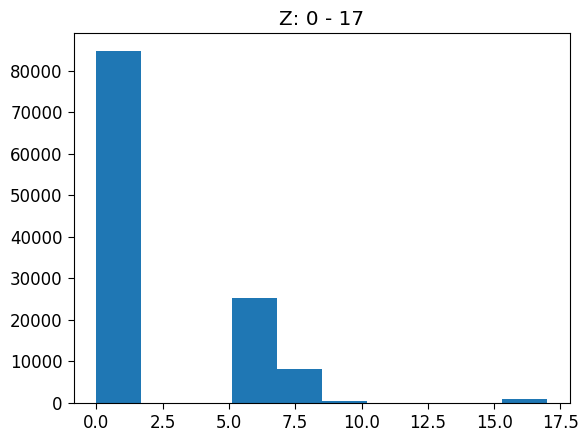

N
(2000,)


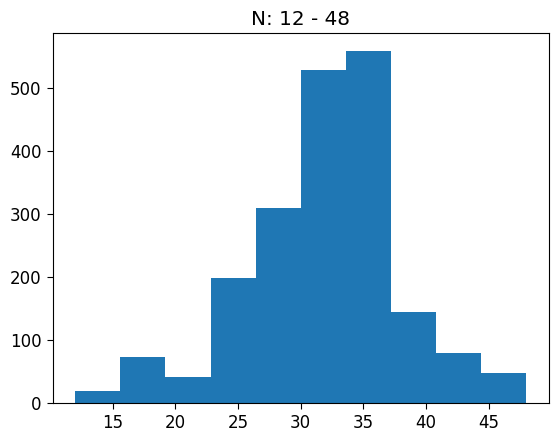

mono
(2000, 60, 1)
esp
(2000, 4953)


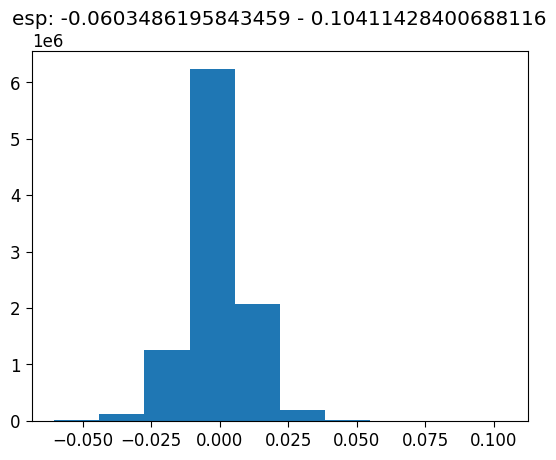

n_grid
(2000,)


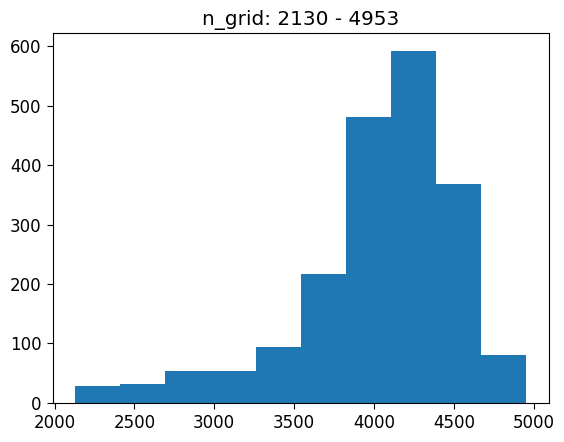

vdw_surface
(2000, 4953, 3)


In [4]:
for k in data_loaded.keys():
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        d = data_loaded[k]
        d = d.flatten()
        plt.hist(d)
        title = f"{k}: {d.min()} - {d.max()}"
        plt.title(title)
        plt.show()

In [8]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [9]:
train_data, valid_data = prepare_datasets(
    key, num_train=1200, num_valid=100,
    filename=[data_path_resolved],
    clean= False, esp_mask=True,
    # clip_esp=True,
)




shape (2000, 60, 3)
R (2000, 60, 3)
(2000, 60, 3)
['R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'espMask']
2000
0 R 2000 (2000, 60, 3)
1 Z 2000 (2000, 60)
2 N 2000 (2000, 1)
3 mono 2000 (2000, 60)
4 esp 2000 (2000, 4953)
5 vdw_surface 2000 (2000, 4953, 3)
6 n_grid 2000 (2000,)
7 espMask 2000 (2000, 4953)


In [10]:
esp_data = train_data["esp"]
esp_data.shape

(1200, 4953)

## Training (1)

In [11]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x7f23ac31e290>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x7f239ff38790>>,
    optimizer_fn: Callable = <function <lambda> at 0x7f239ff39bd0>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = False,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x7f239ff39ab0>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = None,
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x7f239ff39a20>, loss_step_fn=<PjitFunction of <...> tra_metrics=<function _log_extr

In [97]:
# NDCM = 7
models = []
paramsco = []

for NDCM in range(1,8):

    model = MessagePassingModel(
        features=64, max_degree=2, num_iterations=2,
        num_basis_functions=32, cutoff=10.0, n_dcm=NDCM,
        include_pseudotensors=False,
    )
    new_params = None
    
    params, valid_loss = train_model(
        key=key, model=model,
        writer=None,
        train_data=train_data, valid_data=valid_data,
        num_epochs=10, learning_rate=1e-3, batch_size=1,
        ndcm=model.n_dcm, esp_w=10000.0,
    )
    new_params, valid_loss = train_model(
        key=key, model=model,
        writer=None,
        train_data=train_data, valid_data=valid_data,
        num_epochs=10, learning_rate=5e-4, batch_size=1,
        ndcm=model.n_dcm, esp_w=1000.0,
        restart_params=params if new_params is None else new_params,
    )
    new_params, valid_loss = train_model(
        key=key, model=model,
        writer=None,
        train_data=train_data, valid_data=valid_data,
        num_epochs=20, learning_rate=1e-4, batch_size=1,
        ndcm=model.n_dcm, esp_w=1000.0,
        restart_params=params if new_params is None else new_params,
    )
    np.save(f"modelA{NDCM}", new_params)
    models.append(model)
    paramsco.append(new_params)


Preparing batches
..................
Epoch 1 train: 0.3696044385433197, valid: 0.40257924795150757, best: True
Epoch 2 train: 0.25376319885253906, valid: 0.2692112624645233, best: True
Epoch 3 train: 0.20189134776592255, valid: 0.19402477145195007, best: True
Epoch 4 train: 0.1689247488975525, valid: 0.15242944657802582, best: True
Epoch 5 train: 0.15859639644622803, valid: 0.13470099866390228, best: True
Epoch 6 train: 0.14560072124004364, valid: 0.12221656739711761, best: True
Epoch 7 train: 0.13977418839931488, valid: 0.12057636678218842, best: True
Epoch 8 train: 0.12854963541030884, valid: 0.10734941065311432, best: True
Epoch 9 train: 0.11841264367103577, valid: 0.09902044385671616, best: True
Epoch 10 train: 0.11336324363946915, valid: 0.09290596842765808, best: True
Preparing batches
..................
Epoch 1 train: 0.016855206340551376, valid: 0.016374608501791954, best: True
Epoch 2 train: 0.014724553562700748, valid: 0.013153412379324436, best: True
Epoch 3 train: 0.0137714

In [98]:
params['params'].keys()



dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'TensorDense_0', 'element_bias'])

In [99]:
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

?dcmnet_analysis
?prepare_batch

Signature: prepare_batch(path: pathlib.Path, index=0, data=None)
Docstring:
Prepare a single batch from data for analysis.

Parameters
----------
path : Path
    Path to the data file
index : int, optional
    Index of the data to prepare
data : dict, optional
    Data dictionary to use instead of loading from file
    
Returns
-------
dict
    Batch dictionary ready for model input
File:      ~/mmml/mmml/dcmnet/dcmnet/analysis.py
Type:      function

In [100]:
valid_data.keys()

dict_keys(['R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'espMask'])

In [104]:
# batch = prepare_batch(data_files[3], index=9)
batch['com'] = np.mean(batch['R'].T, axis=-1) # center of mass
batch["Dxyz"] = batch["R"] - batch["com"]


output = dcmnet_analysis(new_params, model, batch)
print(output["rmse_model_masked"]), print(output["rmse_model"]);

1.001603
1.001603


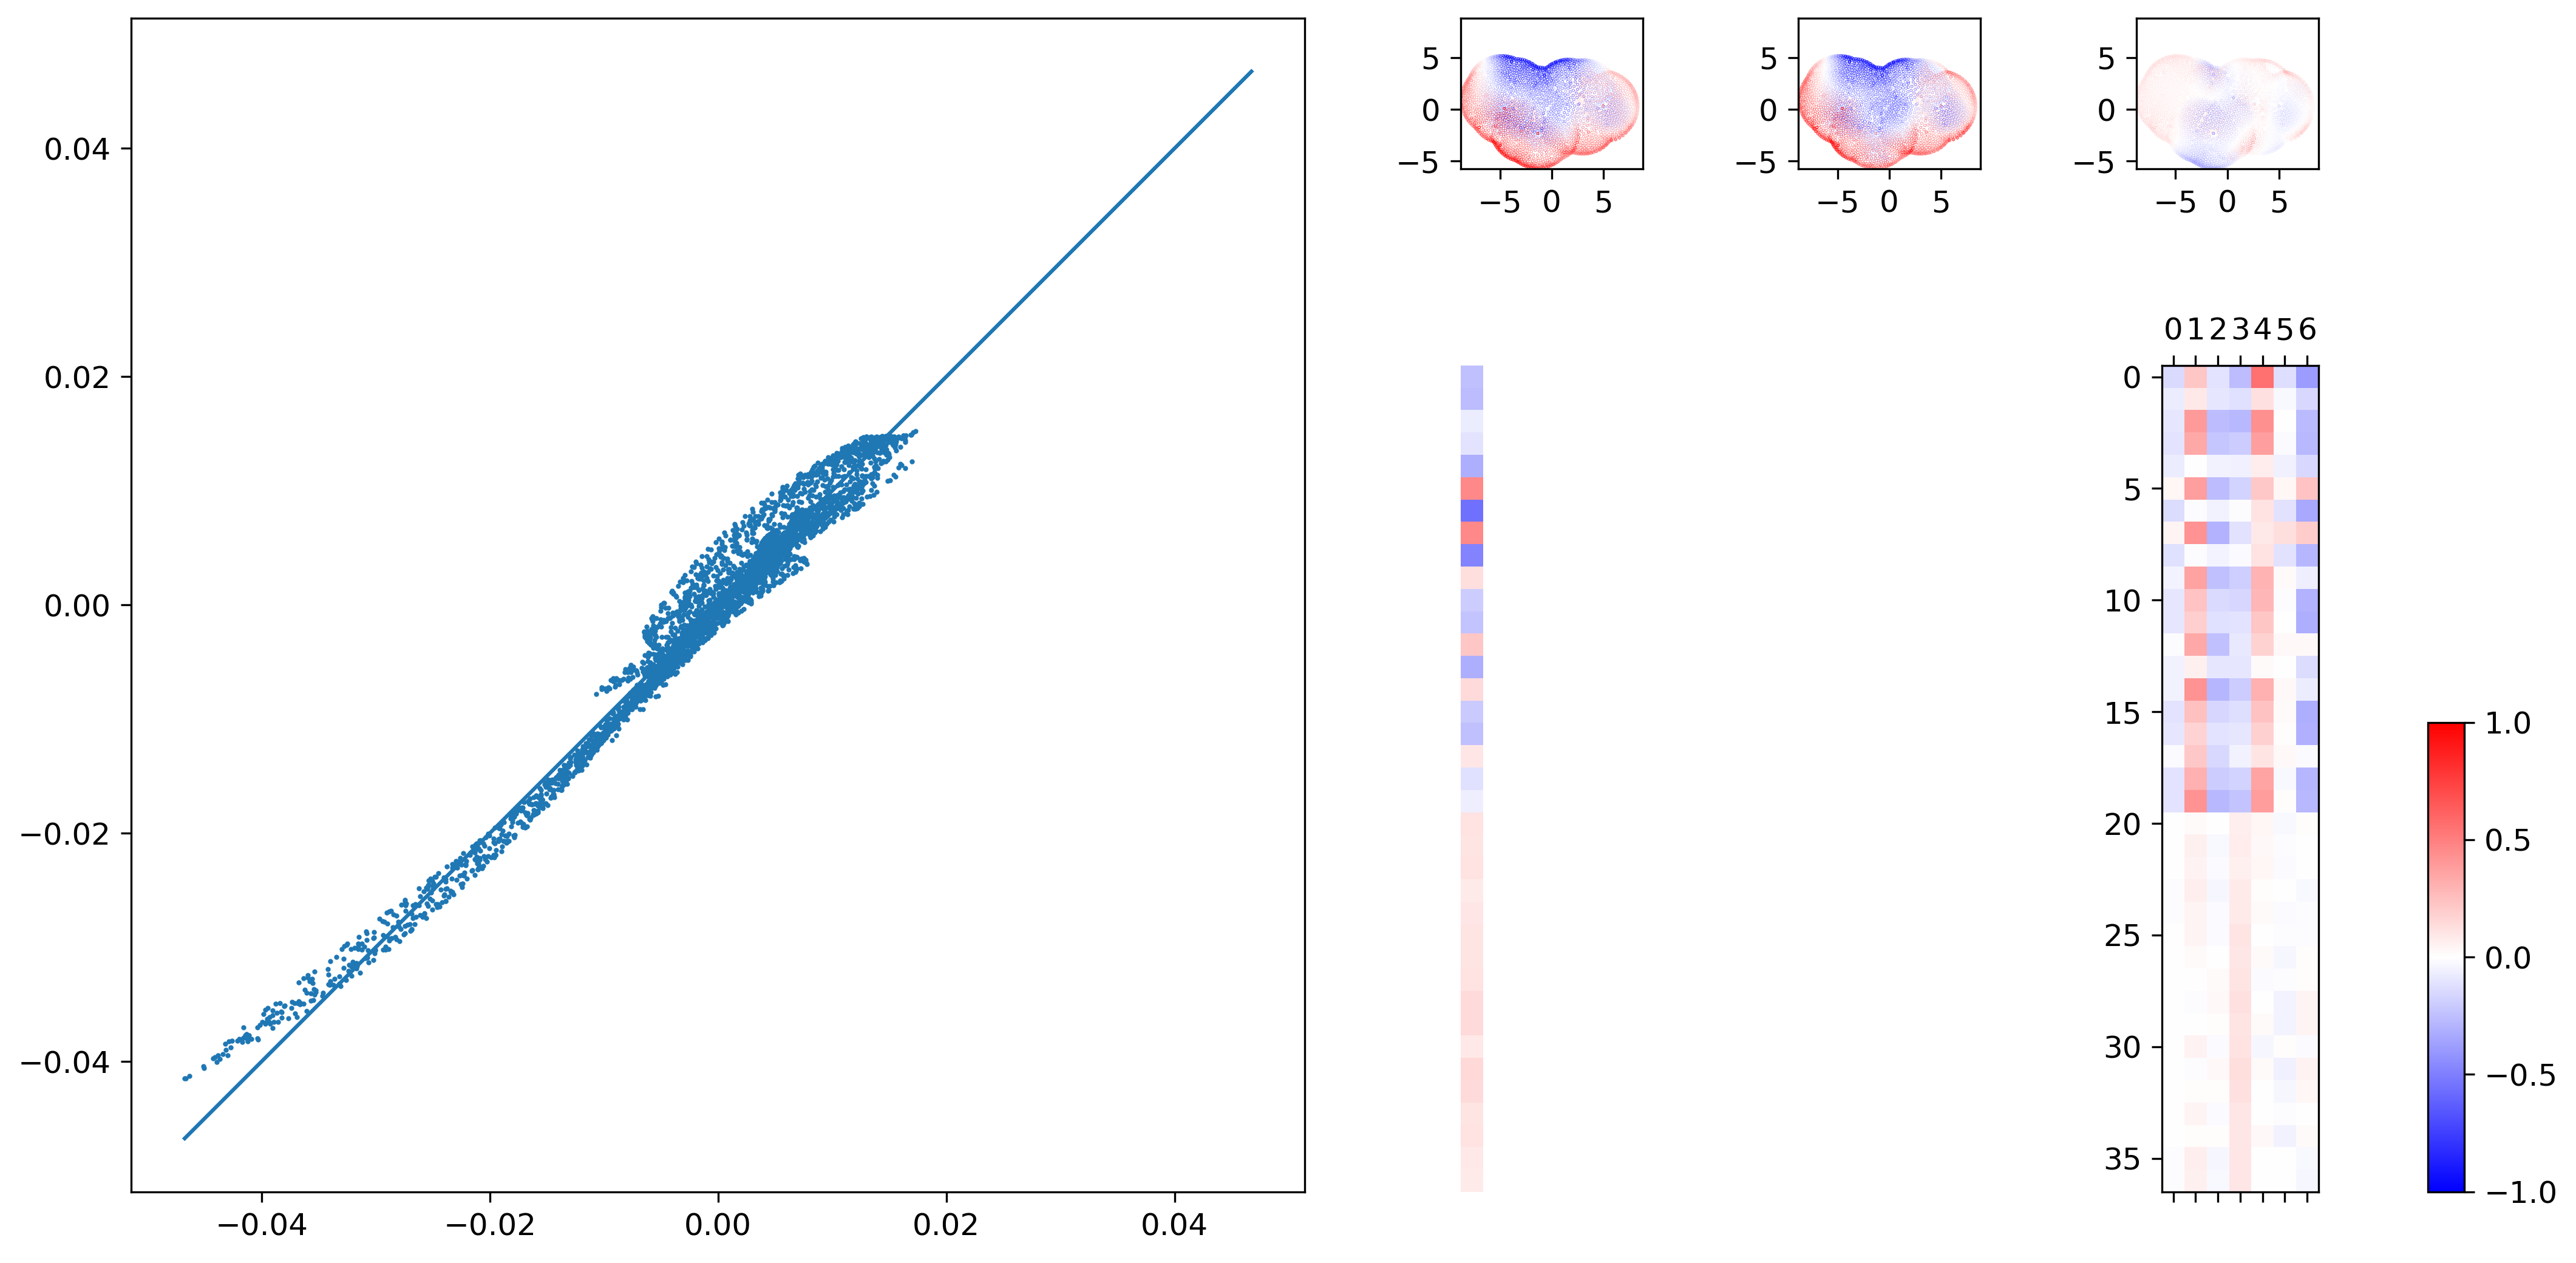

In [105]:
import patchworklib as pw
VMAX = 0.01
xy_ax = pw.Brick()
xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
xy_ax.set_aspect('equal')

ax_true = pw.Brick()
Npoints = 4150
vdw_surface_min = np.min(batch["vdw_surface"][0], axis=0)
vdw_surface_max = np.max(batch["vdw_surface"][0], axis=0)

ax_true.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_true.set_aspect('equal')

ax_pred = pw.Brick()

ax_pred.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_pred.set_aspect('equal')


ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
ax_diff.set_aspect('equal')

for _ in [ax_pred, ax_true, ax_diff]:
    _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
    _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])

charge_ax = pw.Brick()
charge_ax.matshow(output["mono"][0][:int(batch["N"])],vmin=-1,vmax=1)
scharge_ax = pw.Brick()
scharge_ax.matshow(output["mono"][0][:int(batch["N"])].sum(axis=-1)[:, None],vmin=-1,vmax=1)
# scharge_ax.add_colorbar(vmin=-1,vmax=1)
scharge_ax.axis("off")
f = xy_ax | ((ax_pred | ax_true | ax_diff) /  (scharge_ax | charge_ax))
f.add_colorbar(vmin=-1,vmax=1)



In [106]:
R = output["dipo"][:int(batch["N"])*NDCM]
Z = np.array([1 if _ > 0 else 1 for _ in output["mono"][0][:int(batch["N"])].flatten()])
R.shape, Z.shape
dcm_atoms = ase.Atoms(Z, R)
view(dcm_atoms,  viewer="x3d",
viewer_kwargs={"width": 1000, "height": 1000, "show_unit_cell": 1})

In [103]:
import ase
from ase.visualize import view
atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
batch["R"][:int(batch["N"])])
view(atoms, viewer="x3d")


In [116]:
import numpy as np
import jax
import jax.numpy as jnp
import sys
import os


from mmml.dcmnet.dcmnet_mcts import optimize_dcmnet_combination, DCMNETSelectionEnv

In [119]:
# Import DCMNET components
from mmml.dcmnet.dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from mmml.dcmnet.dcmnet.loss import esp_mono_loss
from mmml.dcmnet.dcmnet.electrostatics import calc_esp
from mmml.dcmnet.dcmnet.utils import apply_model

In [131]:
mono, dipo = apply_model(model, params, batch, 1)
dipo = dipo.reshape(60, mono.shape[-1], 3)
mono = mono.squeeze()[...,None]
dipo.shape, mono.shape

((60, 7, 3), (60, 7, 1))

(1, 60, 7)

In [71]:
print("1. Molecular System:")
print(f"   - {len(molecular_data['atomic_numbers'])} atoms")
print(f"   - Atomic numbers: {molecular_data['atomic_numbers']}")
print(f"   - Atom positions:")
for i, pos in enumerate(molecular_data['positions']):
    print(f"     Atom {i}: {pos}")

print("\n2. Available Models and Charges:")
total_charges = 0
for model_id, charges in model_charges.items():
    n_charges = charges.shape[1]
    total_charges += n_charges
    print(f"   - DCM{model_id+1}: {n_charges} charges per atom")
    print(f"     Example charges for atom 0: {charges[0].tolist()}")
    print(f"     Example positions for atom 0:")
    for j, pos in enumerate(model_positions[model_id][0]):
        print(f"       Charge {j}: {pos}")

print(f"\n   Total charges per atom across all models: {total_charges}")
print(f"   Total possible charge combinations: {total_charges ** len(molecular_data['atomic_numbers'])}")

print("\n3. Creating DCMNET Selection Environment...")
env = DCMNETSelectionEnv(molecular_data, esp_target, vdw_surface, model_charges, model_positions)

print(f"   - Environment state shape: {env.selected_charges.shape}")
print(f"   - Charge mapping: {env.charge_mapping}")
print(f"   - Legal actions: {len(env.legal_actions())} possible (atom_idx, charge_idx) pairs")

print("\n4. Running MCTS Optimization...")
best_selection, best_loss = optimize_dcmnet_combination(
    molecular_data=molecular_data,
    esp_target=esp_target,
    vdw_surface=vdw_surface,
    model_charges=model_charges,
    model_positions=model_positions,
    n_simulations=100,  # Small number for demo
    temperature=1.0
)